In [33]:
# Step 1: Imports and GPU Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Confirm GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ GPU available: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("❌ GPU not found")

✅ GPU available: /physical_device:GPU:0


In [3]:
m1="CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv"
t1="CIC-IDS-2017/Tuesday-WorkingHours.pcap_ISCX.csv"
w1="CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv"
th1="CIC-IDS-2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
th2="CIC-IDS-2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f1="CIC-IDS-2017/Friday-WorkingHours-Morning.pcap_ISCX.csv"
f2="CIC-IDS-2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f3="CIC-IDS-2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"

dm1 = pd.read_csv(m1)
dt1 = pd.read_csv(t1)
dw1 = pd.read_csv(w1)
dth1 = pd.read_csv(th1)
dth2 = pd.read_csv(th2)
df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)

In [11]:
df = pd.concat([dm1,dt1,dw1,dth1,dth2,df1, df2, df3], axis=0)
#dm1,dt1,dw1,dth1,dth2,df1, df2, df3

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

In [12]:
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

class_names=le.classes_

In [13]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [14]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Reshape for Conv1D input
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [24]:
# Check input shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (2262300, 78, 1)
y_train shape: (2262300,)


In [26]:
from tensorflow.keras.utils import to_categorical

# One-hot encode y
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Check shape
print(y_train_cat.shape)
print(y_test_cat.shape)

(2262300, 15)
(565576, 15)


In [28]:
# CNN + LSTM Model Architecture
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(y_train_cat.shape[1], activation='softmax')  # Use correct number of output classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Train the model with EarlyStopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
14140/14140 [==============================] - 87s 6ms/step - loss: 0.1769 - accuracy: 0.9384 - val_loss: 0.0749 - val_accuracy: 0.9654
Epoch 2/10
14140/14140 [==============================] - 103s 7ms/step - loss: 0.0644 - accuracy: 0.9736 - val_loss: 0.0506 - val_accuracy: 0.9788
Epoch 3/10
14140/14140 [==============================] - 108s 8ms/step - loss: 0.0506 - accuracy: 0.9792 - val_loss: 0.0417 - val_accuracy: 0.9818
Epoch 4/10
14140/14140 [==============================] - 111s 8ms/step - loss: 0.0467 - accuracy: 0.9807 - val_loss: 0.0399 - val_accuracy: 0.9823
Epoch 5/10
14140/14140 [==============================] - 86s 6ms/step - loss: 0.0437 - accuracy: 0.9819 - val_loss: 0.0438 - val_accuracy: 0.9827
Epoch 6/10
14140/14140 [==============================] - 82s 6ms/step - loss: 0.0421 - accuracy: 0.9827 - val_loss: 0.0402 - val_accuracy: 0.9837
Epoch 7/10
14140/14140 [==============================] - 80s 6ms/step - loss: 0.0413 - accuracy: 0.9829 - val_loss

In [ ]:
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

# Predictions and Classification Report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)



Test Accuracy: 0.9829
17675/17675 [==============================] - 32s 2ms/step


NameError: name 'classification_report' is not defined

In [45]:
print("\tCNN + LSTM Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, digits=4, target_names=class_names))

	CNN + LSTM Classification Report:
                            precision    recall  f1-score   support

                    BENIGN     0.9910    0.9879    0.9894    454394
                       Bot     0.9298    0.3759    0.5354       423
                      DDoS     0.9996    0.9829    0.9912     25708
             DoS GoldenEye     0.9850    0.9503    0.9674      2074
                  DoS Hulk     0.9816    0.9643    0.9729     45782
          DoS Slowhttptest     0.8944    0.9775    0.9341      1109
             DoS slowloris     0.9621    0.9786    0.9702      1166
               FTP-Patator     0.9962    0.9924    0.9943      1572
                Heartbleed     0.0000    0.0000    0.0000         2
              Infiltration     0.0000    0.0000    0.0000         7
                  PortScan     0.8730    0.9619    0.9153     31779
               SSH-Patator     0.9011    0.9450    0.9225      1128
  Web Attack � Brute Force     0.7714    0.0879    0.1579       307
Web Attack �

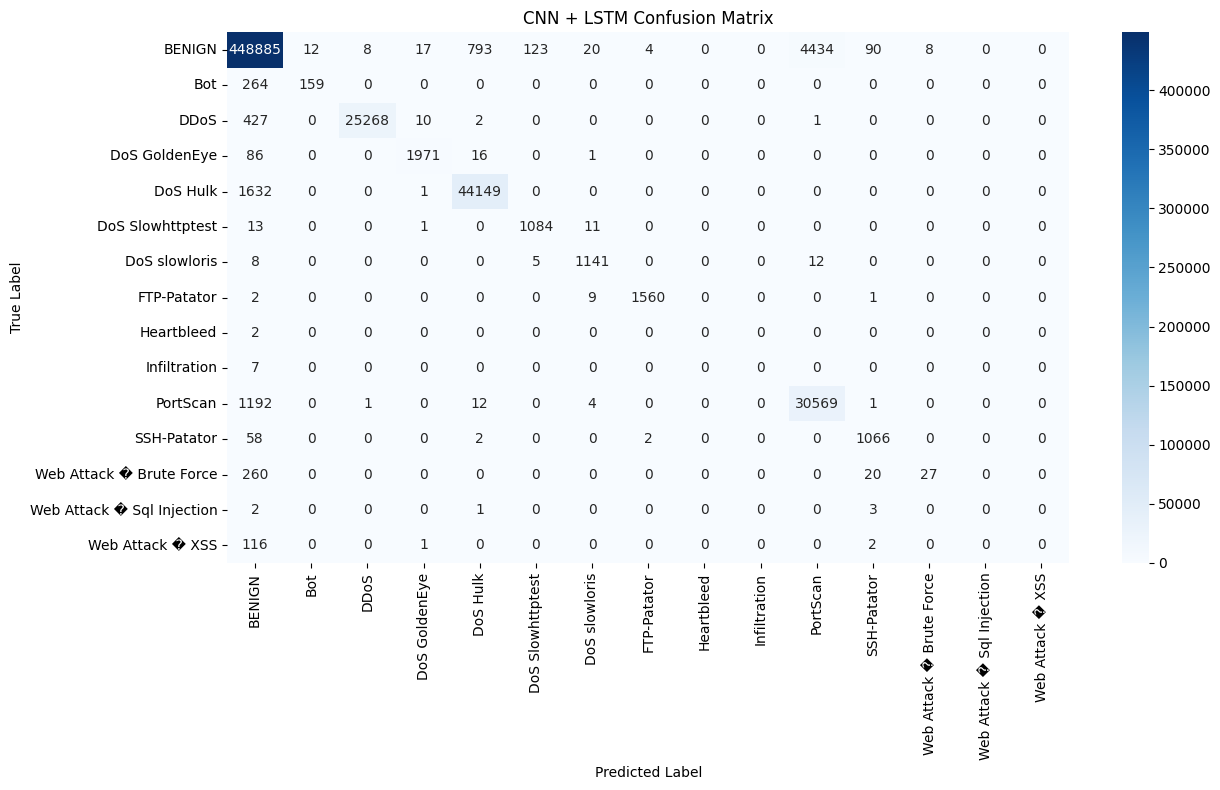

In [43]:
# Create confusion matrix for XGBoost
plt.figure(figsize=(13, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN + LSTM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('cnn+lstm_confusion_matrix.png')
plt.show()

7/7 [==============================] - 0s 10ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/50 [00:00<?, ?it/s]

625/625 [==============================] - 1s 2ms/step


<Figure size 1200x800 with 0 Axes>

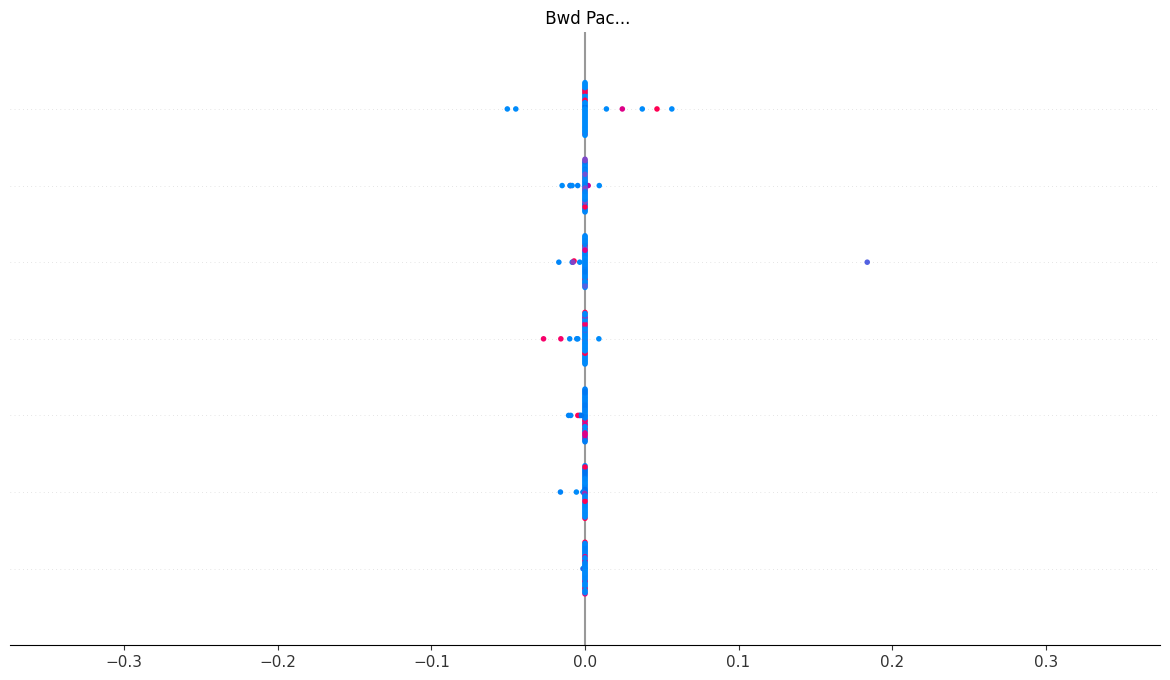

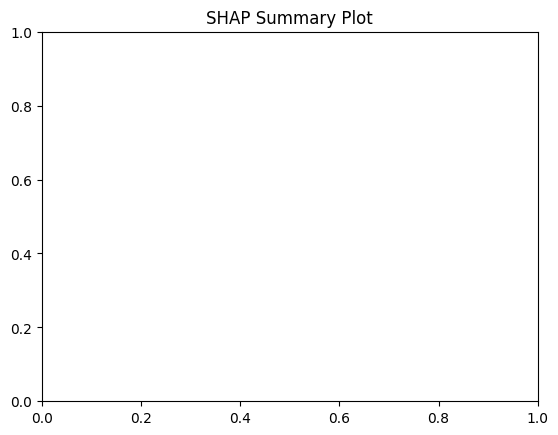

In [36]:
# SHAP - KernelExplainer
X_sample = X_train[:200].reshape(200, X_train.shape[1])  # Flatten for SHAP input
X_test_flat = X_test[:50].reshape(50, X_test.shape[1])

explainer = shap.KernelExplainer(lambda x: model.predict(x.reshape((x.shape[0], x.shape[1], 1))), X_sample)
shap_values = explainer.shap_values(X_test_flat, nsamples=100)

# Mean absolute SHAP values per feature
mean_abs_shap = np.mean(np.abs(shap_values[0]), axis=0)

# Plot top features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_flat, feature_names=X.columns.tolist())
plt.title("SHAP Summary Plot")
plt.show()

In [37]:
# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.mean(np.abs(shap_values[0]), axis=0)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mean_abs_shap
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Features by SHAP Importance')
plt.tight_layout()
plt.show()


ValueError: All arrays must be of the same length

In [39]:
feature_names = ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
        'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max',
        'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
        'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
        'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean',
        'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean',
        'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
        'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
        'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
        'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
        'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
        'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
        'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length',
        'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
        'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
        'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
        'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
        'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std',
        'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']

AssertionError: Feature and SHAP matrices must have the same number of rows!

<Figure size 640x480 with 0 Axes>

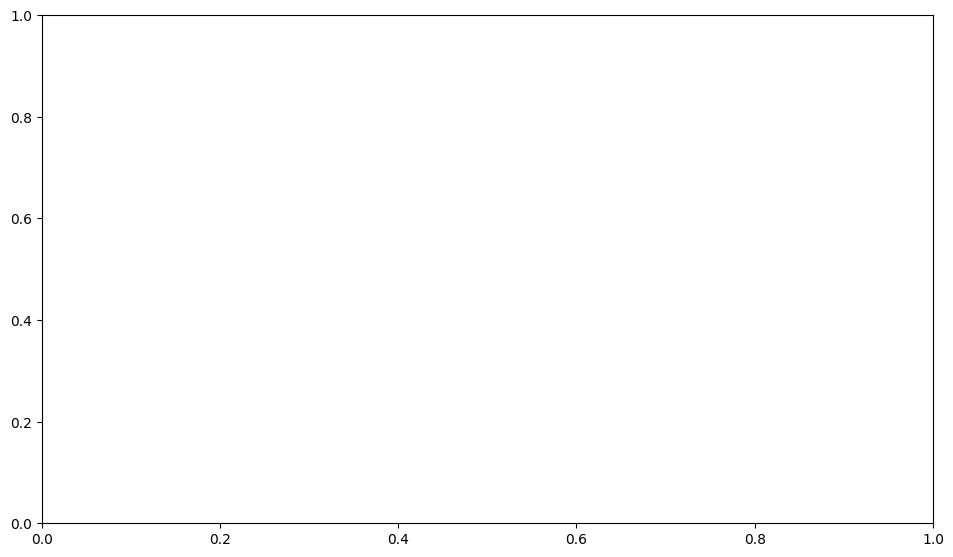

In [40]:
import shap
import matplotlib.pyplot as plt

# Check if shap_values is a list (multi-class)
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, plot_type="dot", show=False)
else:
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="dot", show=False)

# Customize plot size
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()
